In [17]:
%matplotlib inline
import sys

from u8timeseries import Prophet, KthValueAgoBaseline, ExponentialSmoothing, TimeSeries, Arima, AutoArima
from u8timeseries import StandardRegressiveModel
from u8timeseries.metrics import mape, overall_percentage_error, mase
from u8timeseries.backtesting import simulate_forecast_ar, simulate_forecast_regr, get_train_val_series, backtest_autoregressive_model

import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

## Read data

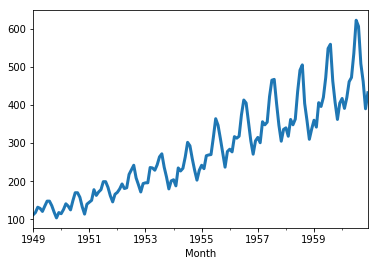

In [3]:
df = pd.read_csv('AirPassengers.csv')
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
series.pd_series().plot(lw=3)

## Build three models

In [4]:
model_es = ExponentialSmoothing()
model_pr = Prophet()
# model_ar = Arima(2, 1, 5)
model_bl = KthValueAgoBaseline(K=12)

## Try one of the models
Here we'll just do a one shot prediction. Prediction time will be 1957-01-01, and we'll forecast the rest of the time series from that point on.

Definition: *prediction time* is the time *at which* a forecast is made, and *forecast time* is the time *for which* the forecast is made.

For instance, in the example below, prediction time is 1957-01-01, and forecast time is the time range between 1957-02-01 and the end of the time series.

In [7]:
train, val = series.split_after(pd.Timestamp('19570101'))
model_es.fit(train)
pred = model_es.predict(len(val))

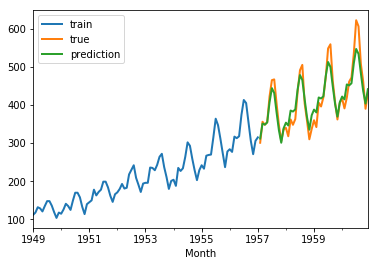

In [6]:
train.plot(lw=2, label='train')
val.plot(lw=2, label='true')
pred.plot(lw=2, label='prediction')
plt.legend()

## Simulate historical forecasting
Here we'll do some backtesting. We will simulate predictions that would have been done historically with a given model. It can take a while to produce, since the model is re-fit every time the simulated prediction time advances.

Such simulated forecasts are always defined with respect to a *forecast horizon*, which is the number of time steps that separate the prediction time from the forecast time. In the example below, we simulate forecasts done for 6 months in the future (compared to prediction time).

In [9]:
historical_fcast = simulate_forecast_ar(series, model_es, pd.Timestamp('19570101'), fcast_horizon_n=6, verbose=True)

Let's see what this backtest forecast looks like. You can see it produces more accurate predictions than the one-off prediction done above, because here the model is re-fit every month.

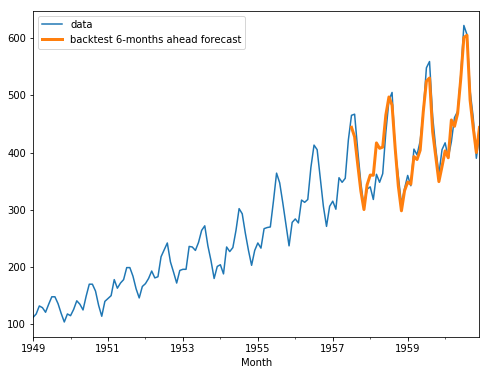

In [14]:
plt.figure(figsize=(8,6))
series.plot(label='data')
historical_fcast.plot(lw=3, label='backtest 6-months ahead forecast')
plt.legend()

## Backtest the models on the data using a user-defined metric
Here we'll do slightly more advanced backtesting, and use our own metric (in this case the MAPE error function) to compare the different models. We'll simulate 12-months ahead predictions done in the past, starting in January 1955, and the errors will be computed on the 12-months period for which forecasts are done.

In [20]:
def backtest_model(model):
    tic = time.time()
    train_val_series = get_train_val_series(series, start=pd.Timestamp('19550101'), nr_points_val=12)
    res = backtest_autoregressive_model(model, train_val_series, mape)
    tac = time.time()
    print('Backtest done in %.2f s.' % (tac-tic))
    return res

In [21]:
res_es = backtest_model(model_es)
res_pr = backtest_model(model_pr)
res_bl = backtest_model(model_bl)

Backtest done in 61.50 s.


/Users/julien/anaconda3/envs/timeseries/lib/python3.6/site-packages/fbprophet/forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


Backtest done in 124.62 s.
Backtest done in 0.81 s.


### Plot the user-defined backtesting results

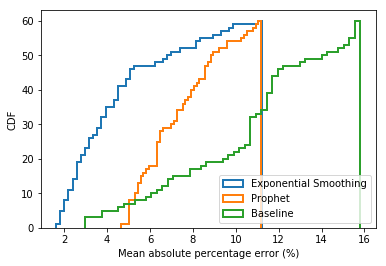

In [22]:
plt.hist(res_es, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Exponential Smoothing');
plt.hist(res_pr, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Prophet');
plt.hist(res_bl, bins=50, cumulative=True, histtype='step', 
         lw=2, label='Baseline');

plt.xlabel('Mean absolute percentage error (%)')
plt.ylabel('CDF')
plt.legend(loc=4)

### Let's make an actual forecast!
Since Exponential Smoothing is better in backtests, let's use this one.

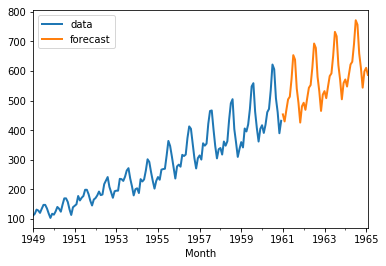

In [23]:
model_es.fit(series)
pred = model_es.predict(n = 50)

series.pd_series().plot(label='data', lw=2)
pred.pd_series().plot(label='forecast', lw=2)
plt.legend()

## Ensembling several predictions
### Let's simulate forecasts done by an ensemble of models

In [24]:
""" New way - backtest over time
"""
models = [ExponentialSmoothing(), Prophet()]

historical_ar_preds = [simulate_forecast_ar(series, m, pd.Timestamp('19570101'), fcast_horizon_n=6, verbose=True)
                       for m in models]

/Users/julien/anaconda3/envs/timeseries/lib/python3.6/site-packages/fbprophet/forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()


In [25]:
""" Combine the individual simulated predicitons
"""
regrModel = StandardRegressiveModel(train_n_points=12)

series_val = series.intersect(historical_ar_preds[0])

historical_pred = simulate_forecast_regr(historical_ar_preds, series_val, regrModel,
                                         pd.Timestamp('19580101'), fcast_horizon_n=6)

..............................

MAPE Error Exponential smoothing: 3.085182778846173
MAPE Error Prophet: 7.213946499477634
MAPE Error ensemble: 5.513394191900889


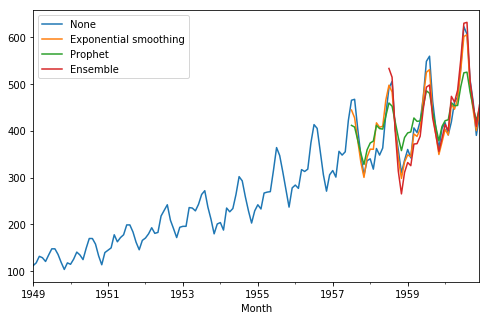

In [28]:
""" Compute errors and plot
"""
plt.figure(figsize=(8,5))

series.plot()
for i, m in enumerate(models):
    historical_ar_preds[i].plot(label=str(m))
    
    # intersect last part, to compare everything with ensemble
    ar_pred = historical_ar_preds[i].intersect(historical_pred)
       
    mape_er = mape(series.intersect(historical_pred), ar_pred)
    print('MAPE Error {}: {}'.format(m, mape_er))

print('MAPE Error ensemble: {}'.format(mape(series.intersect(historical_pred), historical_pred)))

historical_pred.plot(label='Ensemble')

plt.legend()

## Example of forecasting using a regressive model and extra features